### Multi-omic Dataset: Latent representation using Autoencoders
- Load Data
- Normalize Data
- Define Autoencoder Model
- Train Autoencoder with normalized dataset
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [1]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

X_train_norm, X_train_swapped, X_test_norm, y_train, y_test, y_train_oh, y_test_oh = Models.prepare_datasets(X_renal_data.iloc[:,1:],y_renal_data["label"], test_size=0.2, swap_noise=0.15)

# We will use "X_train_norm" as training dataset for the Autoencoder

swapping: 65 rows.


In [2]:
import importlib
importlib.reload(Models)

<module 'Models' from 'C:\\Desarrollo\\Data Science\\Jupyter Notebooks\\Stage\\oss-stage-2019\\Singleomic Dataset\\Models.py'>

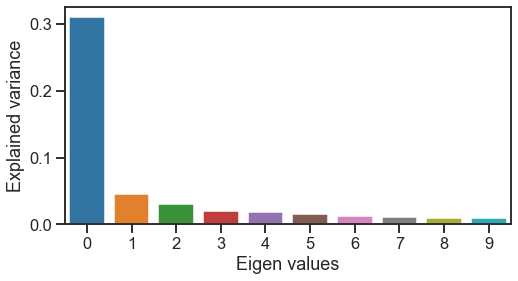

PCA on single-modal explained variance ratio: 0.48103795292302987


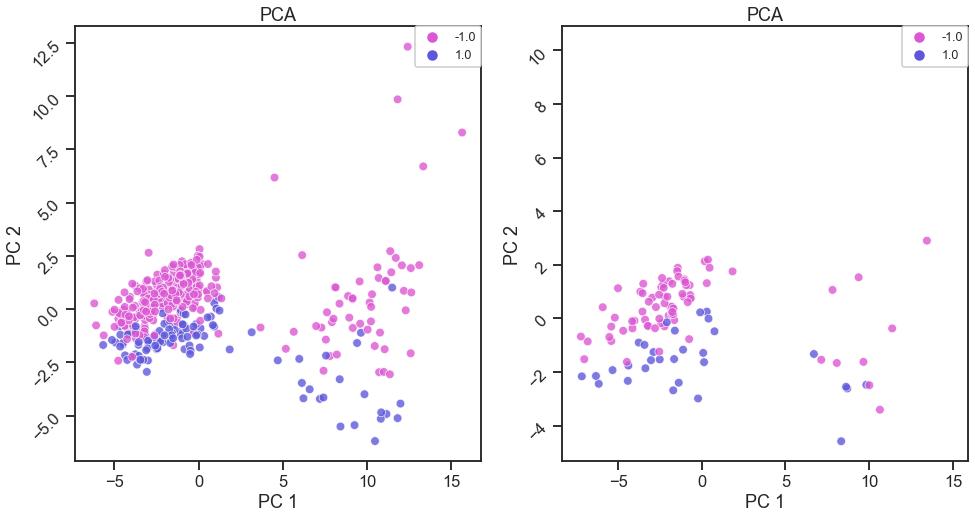

Compression: 102.52

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00068: early stopping


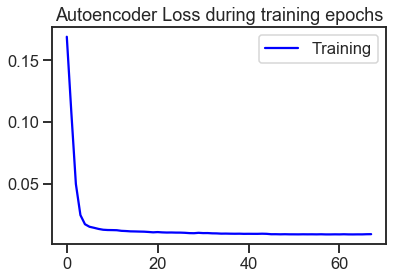

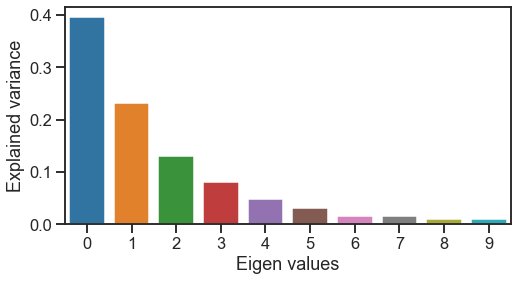

PCA on single-modal explained variance ratio: 0.9705789602950349


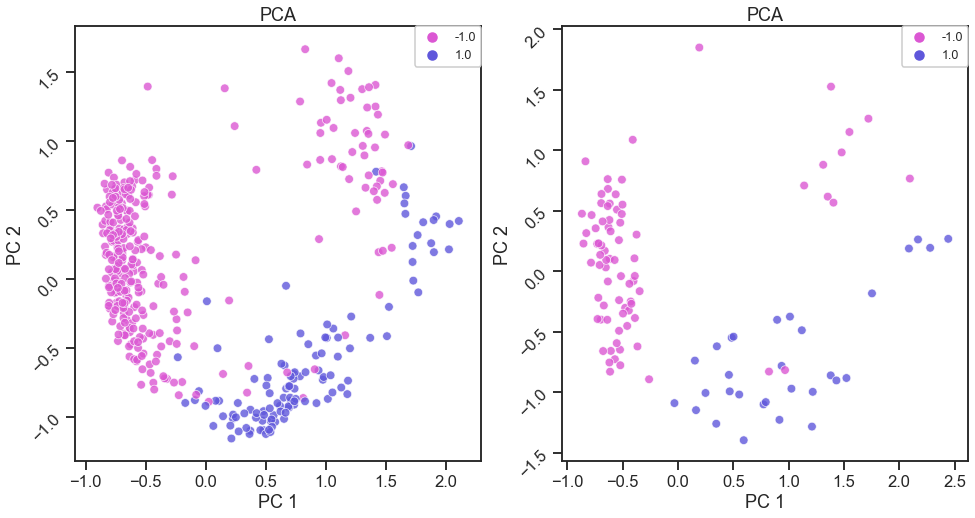

Results for AE: 

[[76  3]
 [ 2 28]]


              precision    recall  f1-score   support

          -1       0.97      0.96      0.97        79
           1       0.90      0.93      0.92        30

    accuracy                           0.95       109
   macro avg       0.94      0.95      0.94       109
weighted avg       0.95      0.95      0.95       109

Training set score for Logistic Regression: 0.960739
Testing  set score for Logistic Regression: 0.954128
[[77  2]
 [ 3 27]]


              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.93      0.90      0.92        30

    accuracy                           0.95       109
   macro avg       0.95      0.94      0.94       109
weighted avg       0.95      0.95      0.95       109

Training set score for SVM: 0.958430
Testing  set score for SVM: 0.954128
[[76  3]
 [ 1 29]]


              precision    recall  f1-score   support

          -1       0.99      0

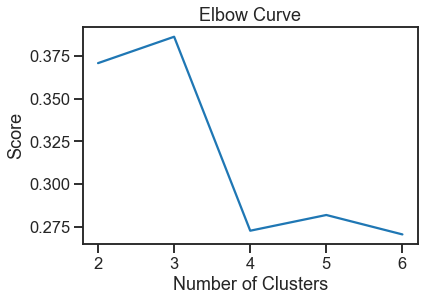

mutual information: 0.0008776597682347498
AE 2 clusters -  silhoutte score: 0.41743627190589905
AE 3 clusters -  silhoutte score: 0.41810381412506104
AE 4 clusters -  silhoutte score: 0.3908524513244629
AE 5 clusters -  silhoutte score: 0.3819139897823334
AE 6 clusters -  silhoutte score: 0.3593551516532898


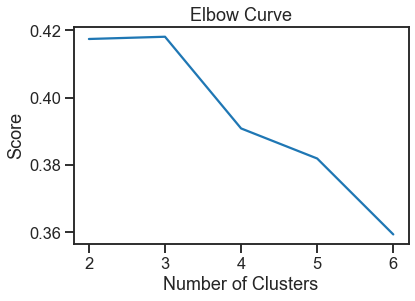

mutual information: 0.4379384535449505
AE 2 clusters -  silhoutte score: 0.36315101385116577
AE 3 clusters -  silhoutte score: 0.3832368552684784
AE 4 clusters -  silhoutte score: 0.24219870567321777
AE 5 clusters -  silhoutte score: 0.24844016134738922
AE 6 clusters -  silhoutte score: 0.2383529096841812


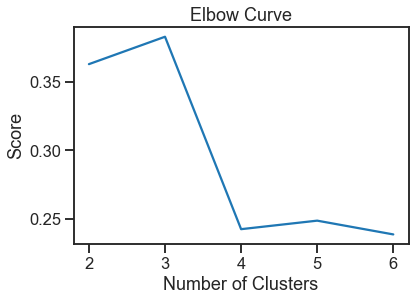

In [2]:
###  Hyperparamter tuning
# MAP y_train from classes -1 and 1 to 0 and 1
y_train_map = ((y_train + 1)/2).astype(int)

### VISUALIZATION WITH PCA
## ORIGINAL DATASET
X_latent_pca, X_latent_test_pca = Models.perform_PCA(X_train_norm, X_test_norm, y_train, y_test, n_components=10)

dropouts = [0.01]
l1s = [0]
l2s = [0.000005]
scores = []
for dropout in dropouts:
    for l1 in l1s:
        for l2 in l2s:
            ## Build and Train Autoencoder
            autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_norm,
                                                                          X_train_norm,
                                                                          encoding_dim=50, 
                                                                          regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                          dropout=dropout,
                                                                          epochs=200)
            ## Encode datasets
            X_latent_ae = Models.encode_dataset(X_train_norm, encoder)
            X_latent_test_ae = Models.encode_dataset(X_test_norm, encoder)
         
            ## PCA ON AUTOENCODER LATENT SPACE
            X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_ae, X_latent_test_ae, y_train, y_test, n_components=10)

            ### CLASSIFICATION ###
            # We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.
            lr_accuracy, svm_accuracy, rf_accuracy = Models.classify(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")

            ### CLUSTERING ###
            silhouette_kmeans, mutual_info_kmeans, silhouette_spectral, mutual_info_spectral, silhouette_hierarchical, mutual_info_hierarchical = Models.cluster(X_latent_ae,y_train_map, model_type="AE")

            scores.append((dropout,l1,l2,loss,lr_accuracy,svm_accuracy,rf_accuracy,silhouette_kmeans, mutual_info_kmeans, silhouette_spectral, mutual_info_spectral, silhouette_hierarchical, mutual_info_hierarchical))


In [3]:
scores = pd.DataFrame(scores,
                      columns=["dropout","l1","l2","loss","LR_accuracy","SVM_accuracy", "RF_accuracy","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,dropout,l1,l2,loss,LR_accuracy,SVM_accuracy,RF_accuracy,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
0,0.01,0,0.000005,0.008924,0.954128,0.954128,0.963303,0.370739,0.423126,0.417436,0.000878,0.363151,0.437938


### RESULTS 

| Encoding dim  | l1      | l2      | Dropout  | Loss   | Accuracy (LR) | Accuracy (SVM) | Accuracy (RF) | Silohuette Score (K-means) | Mutual Information (K-means) |
|---------------|---------|---------|----------|--------|---------------|----------------|---------------|----------------------------|------------------------------|
| 50            | 0       | 0       | 0        | 0.009  |  0.95         | 0.96           | 0.91          | 0.55                       | 0.4260                       |
| 50            | 0       | 0       | 0.01     | 0.009  |  0.95         | 0.96           | 0.95          | 0.44                       | 0.3813                       |
| 50            | 0       | 0       | 0.05     | 0.0094 |  0.87         | 0.92           | 0.88          | 0.45                       | 0.3079                       |
| 50            | 0       | 0       | **0.1**      | 0.0094 |  0.96         | 0.98           | 0.96          | 0.59                       | 0.4695                       |
| 50            | 0       | 0       | 0.15     | 0.0097 |  0.95         | 0.77           | 0.92          | 0.51                       | 0.1563                       |
| 50            | 0       | 0       | 0.20     | 0.0097 |  0.95         | 0.92           | 0.92          | 0.48                       | 0.3555                       |
| 50            | 0       | 0       | 0.30     | 0.0096 |  0.96         | 0.97           | 0.95          | 0.41                       | 0.4501                       |
| 50            | 0       | 0       | 0.40     | 0.0097 |  0.96         | 0.91           | 0.96          | 0.46                       | 0.0020                       |
| 50            | 0       | 0       | 0.50     | 0.0100 |  0.95         | 0.95           | 0.97          | 0.49                       | 0.4412                       |
|---------------|---------|---------|----------|--------|---------------|----------------|---------------|----------------------------|------------------------------|
| 50            | **0**   | 0       | 0.10     | 0.0099 |  0.96         | 0.97           | 0.95          | 0.60                       | 0.4585                       |
| 50            | 0.000001| 0       | 0.10     | 0.0115 |  0.95         | 0.95           | 0.96          | 0.45                       | 0.4671                       |
| 50            | 0.00001 | 0       | 0.10     | 0.0147 |  0.95         | 0.97           | 0.95          | 0.52                       | 0.4738                       |
| 50            | 0.0001  | 0       | 0.10     | 0.0143 |  0.93         | 0.95           | 0.94          | 0.67                       | 0.0010                       |
| 50            | 0.001   | 0       | 0.10     | 0.0151 |  0.72         | 0.72           | 0.65          | 0.84                       | 0.0008                       |
|---------------|---------|---------|----------|--------|---------------|----------------|---------------|----------------------------|------------------------------|
| 50            | 0       | 0       | 0.10     | 0.0095 |  0.88         | 0.73           | 0.90          | 0.43                       | 0.1163                       |
| 50            | 0       | 0.000001| 0.10     | 0.0102 |  0.82         | 0.86           | 0.88          | 0.41                       | 0.4611                       |
| 50            | 0       | **0.000005**| 0.10     | 0.0111 |  0.95         | 0.97           | 0.96          | 0.59                       | 0.4271                       |
| 50            | 0       | 0.00001 | 0.10     | 0.0108 |  0.94         | 0.94           | 0.95          | 0.40                       | 0.3934                       |
| 50            | 0       | 0.00005 | 0.10     | 0.0132 |  0.86         | 0.90           | 0.88          | 0.52                       | 0.4355                       |
| 50            | 0       | 0.0001  | 0.10     | 0.0142 |  0.96         | 0.97           | 0.95          | 0.55                       | 0.4490                       |
| 50            | 0       | 0.001   | 0.10     | 0.0122 |  0.92         | 0.91           | 0.93          | 0.61                       | 0.2537                       |
| 50            | 0       | 0.01    | 0.10     | 0.0117 |  0.72         | 0.72           | 0.66          | 0.82                       | 0.0004                       |
| 50            | 0       | 0.1     | 0.10     | 0.0141 |  0.72         | 0.72           | 0.33          | 0.82                       | 0.0007                       |
|---------------|---------|---------|----------|--------|---------------|----------------|---------------|----------------------------|------------------------------|
| 100           | 0       | 0       | 0.05     | 0.0096 |  0.96         | 0.96           | 0.95          | 0.53                       | 0.4738                       |
| 100           | 0.000001| 0.000005| 0.05     | 0.0113 |  0.95         | 0.94           | 0.95          | 0.39                       | 0.4530                       |
| 100           | 0       | 0.000005| 0.10     | 0.0110 |  0.95         | 0.94           | 0.95          | 0.45                       | 0.4660                       |
| 100           | **0.000001**| **0.000001**| **0.10**| 0.0118 |  0.96         | 0.98           | 0.96          | 0.43                       | 0.4359                       |
| 100           | 0       | 0.000001| 0.15     | 0.0098 |  0.94         | 0.95           | 0.94          | 0.44                       | 0.4759                       |
| 100           | 0.000001| 0.000005| 0.15     | 0.0106 |  0.96         | 0.94           | 0.97          | 0.36                       | 0.4355                       |
|---------------|---------|---------|----------|--------|---------------|----------------|---------------|----------------------------|------------------------------|
| 200           | **0**       | **0.000001**| **0.05**     | 0.0100 |  0.96         | 0.97           | 0.96          | 0.45                       | 0.4530                       |
| 200           | 0.000001| 0       | 0.05     | 0.0106 |  0.96         | 0.96           | 0.96          | 0.38                       | 0.4573                       |
| 200           | 0.000001| 0.000005| 0.10     | 0.0119 |  0.95         | 0.95           | 0.98          | 0.42                       | 0.3997                       |
